# EDA

In [1]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard library
import os
import json

# External libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rootutils
import hydra

# Local imports
import ml_project_2_mlp.utils as utils

/Users/jonas-mika/Library/Caches/pypoetry/virtualenvs/ml-project-2-mlp-a6NSXBdT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [3]:
# Global paths
ROOT_DIR = root_path
DATA_DIR = os.path.join(ROOT_DIR, "data")
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

In [4]:
# Costs per token based on https://openai.com/pricing
GPT4_COST_PER_INP_TOKEN = 0.00001
GPT4_COST_PER_OUT_TOKEN = 0.00003
GPT3_5_COST_PER_INP_TOKEN = 0.000001
GPT3_5_COST_PER_OUT_TOKEN = 0.000002

In [5]:
rename_dict = {
    "human": "Human",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "context1": "C1",
    "context2": "C2",
    "context3": "C3",
    "zeroshot": "0-shot",
    "oneshot": "1-shot",
    "f1": "Macro F1",
    "acc": "Acc",
    "precision": "Precision",
    "recall": "Recall",
    "lpp": "Labels Per Page",
    "model": "Model",
    "context": "Context",
    "shot": "Shot",
    "gpt-3.5-turbo-1106": "GPT-3.5",
    "gpt-4-1106-preview": "GPT-4",
    False: "0-shot",
    True: "1-shot",
    "Kids_and_Teens": "Kids & Teens",
}

def get_labeler_name(name: str):
    return " + ".join([rename_dict.get(n, n) for n in name.split("-")])

def get_metric_name(name: str):
    if "/" in name:
        split, metric = name.split("/")
        return f"{rename_dict.get(split, split)} {rename_dict.get(metric, metric)}"
    else:
        return rename_dict.get(name, name)

In [6]:
style = "whitegrid"
palette = "gist_stern"
sns.set_style(style)
sns.set_palette(palette)

In [7]:
def get_num_features(feat, data):
    return len([w[feat] for w in data.values() if w[feat] is not None and w[feat] != []])

## Websites

---

There are three copora of websites in this dataset:

* `crowdsourced`: 761 websites from the crowdsourced dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786)
* `curlie`: A filtered version of the [curlie](https://curlie.org) dataset, containing ~1M websites

For each website, the repository contains a CSV file at the path `data/raw/<corpus>.csv` with the two columns - `wid` and `url`. The `wid` is a unique identifier for the website, and the `url` is the URL of the website.

In [8]:
# Initialise Config
crowdsourced_cfg = hydra.compose(config_name="eda", overrides=["data=crowdsourced"])
curlie_cfg = hydra.compose(config_name="eda", overrides=["data=curlie"])

In [9]:
# Load categories
path = os.path.join(DATA_DIR, "meta", "categories.json")
with open(path) as f:
    categories = json.load(f)

print(f"Classifying in {len(categories)} categories: {', '.join(categories)}")

Classifying in 14 categories: Arts, Business, Computers, Games, Health, Home, Kids_and_Teens, News, Recreation, Reference, Science, Shopping, Society, Sports


We will continue by exploring each of our datasets, we will store info about each of the indivudal datasets in a list of dictionaries.

In [10]:
webinfo = []

### Crowdsourced Data

This is the annotations crowdsourced for 840 websites in the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786).

In [11]:
# Raw data
crowdsourced_data= hydra.utils.instantiate(crowdsourced_cfg.data)

raw_data = crowdsourced_data.get_raw_data()
processed_data = crowdsourced_data.get_processed_data()
embedded_data = crowdsourced_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 840


,wid,url
0,1161124,www.pointlesssites.com
1,1081241,www.connecticutplastics.com
2,1162420,99percentinvisible.org
3,1146040,www.medicaid.gov
4,1117243,www.graalonline.com


In [12]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: PointlessSites.com  Fun Things To Do When You're Bored
Description: Are you bored? Want something fun to do? Check out these funny websites, pointless facts and stupid pictures brought to you by Pointless Sites!
Keywords: ['Pointless', 'Sites', 'portal,', 'useless', 'pointlessness']
Tags: ['description', 'viewport', 'author', 'keywords', 'robots', 'copyright']
Domain: pointlesssites
TLD: com


In [13]:
# Setup info dict for original
original_info = dict()

# Save these into a dict
original_info["n"] = len(processed_data)
original_info["tld"] = get_num_features("tld", processed_data) / original_info["n"] * 100
original_info["domain"] = get_num_features("domain", processed_data) / original_info["n"] * 100
original_info["tags"] = get_num_features("metatags", processed_data) / original_info["n"] * 100
original_info["titles"] = get_num_features("title", processed_data) / original_info["n"] * 100
original_info["descriptions"] = get_num_features("description", processed_data) / original_info["n"] * 100
original_info["keywords"] = get_num_features("keywords", processed_data) / original_info["n"] * 100
original_info["links"] = get_num_features("links", processed_data) / original_info["n"] * 100
original_info["sentences"] = get_num_features("sentences", processed_data) / original_info["n"] * 100

for k, v in original_info.items():
    if k != "n":
        print(f"ℹ️ Percentage of sites with {k}: {v:.2f}%")


ℹ️ Percentage of sites with tld: 100.00%
ℹ️ Percentage of sites with domain: 100.00%
ℹ️ Percentage of sites with tags: 93.69%
ℹ️ Percentage of sites with titles: 98.42%
ℹ️ Percentage of sites with descriptions: 54.93%
ℹ️ Percentage of sites with keywords: 19.58%
ℹ️ Percentage of sites with links: 89.88%
ℹ️ Percentage of sites with sentences: 99.08%


### Curlie

This is the random subset of 10,000 websites from the Curlie website index that we wish to re-annotate using GPT labelers.

In [14]:
# Raw data
curlie_data = hydra.utils.instantiate(curlie_cfg.data)

raw_data = curlie_data.get_raw_data()
processed_data = curlie_data.get_processed_data()
embedded_jdata = curlie_data.get_embeddings()

print(f"Total number of samples: {len(raw_data)}")
raw_data.head(5)

Total number of samples: 10000


,wid,url
0,917678,www.winandsoft.fr
1,443072,gaude-ag.de
2,728091,www.housing.ucsb.edu
3,132596,www.daccad.nl
4,464355,www.rockhall.com


In [15]:
# Example of processed website
wid = list(processed_data.keys())[0]
data = processed_data[wid]

print(f"Collected data on {list(data.keys())}")

# Show some examples
print(f"\nTitle: {data['title']}")
print(f"Description: {data['description']}")
print(f"Keywords: {data['keywords']}")
print(f"Tags: {data['metatags']}")
print(f"Domain: {data['domain']}")
print(f"TLD: {data['tld']}")

Collected data on ['title', 'description', 'keywords', 'links', 'sentences', 'metatags', 'tld', 'domain']

Title: Logiciel bibliothèque, médiathèque, vidéothèque.
Description: Logiciel bibliothèque  logiciel permettant le catalogage de tous types de documents ou supports pour les besoins d'une bibliothèque. Le logiciel bibliothèque vous garantit la gestion documentaire la plus efficace (livres, cartes, manuscrits, incunables, etc.).
Keywords: ['logiciel', 'bibliotheque,logiciel', 'mediatheque,logiciel', 'gestion', 'bibliotheque,logiciel', 'gestion', 'mediatheque,logiciel,bibliotheque,mediatheque']
Tags: ['description', 'copyright', 'robots', 'keywords', 'author']
Domain: winandsoft
TLD: fr


In [16]:
curlie_info = dict()

# Save these into a dict
curlie_info["n"] = len(processed_data)
curlie_info["tld"] = get_num_features("tld", processed_data) / curlie_info["n"] * 100
curlie_info["domain"] = get_num_features("domain", processed_data) / curlie_info["n"] * 100
curlie_info["tags"] = get_num_features("metatags", processed_data) / curlie_info["n"] * 100
curlie_info["titles"] = get_num_features("title", processed_data) / curlie_info["n"] * 100
curlie_info["descriptions"] = get_num_features("description", processed_data) / curlie_info["n"] * 100
curlie_info["keywords"] = get_num_features("keywords", processed_data) / curlie_info["n"] * 100
curlie_info["links"] = get_num_features("links", processed_data) / curlie_info["n"] * 100
curlie_info["sentences"] = get_num_features("sentences", processed_data) / curlie_info["n"] * 100

for k, v in curlie_info.items():
    if k != "n":
        print(f"ℹ️ Percentage of sites with {k}: {v:.2f}%")

ℹ️ Percentage of sites with tld: 100.00%
ℹ️ Percentage of sites with domain: 100.00%
ℹ️ Percentage of sites with tags: 95.47%
ℹ️ Percentage of sites with titles: 98.28%
ℹ️ Percentage of sites with descriptions: 62.95%
ℹ️ Percentage of sites with keywords: 27.29%
ℹ️ Percentage of sites with links: 91.62%
ℹ️ Percentage of sites with sentences: 99.03%


### LaTeX Table

In [17]:
# Put the data info into a dataframe
df = pd.DataFrame([original_info, curlie_info], index=["Crowdsourced", "Curlie-10k"]).round(2)

# Change all columns names to include (%)
df.columns = [f"{c} (%)" if c != "n" else c for c in df.columns]

df = df.T

# Save the dataframe to a latex table
position = "!ht"
latex = df.to_latex(
    caption="Percentage of websites with each feature accross our datasets.", 
    label="tab:feature-info",
    escape=True,
    float_format="%.2f",
    position=position
)

# Add \centering right after \begin{table}
latex = latex.replace("\\begin{table}" + f"[{position}]", "\\begin{table}" + f"[{position}]" + "\n\\centering")

# Save the latex table
save_path = os.path.join(root_path, "report", "tables", "feature-info.tex")
with open(save_path, "w") as f:
    f.write(latex)
print(f"✅ Saved table to {save_path}")

✅ Saved table to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/tables/feature-info.tex


## Labelers

---

There are multiple GPT labeler instances that can be used to label the data. The labelers are defined in the labelers module and are identified by a `context`, `model` and `fewshow` parameter. The `context` parameter defines the context that is used to prompt the model. The `model` parameter defines the model that is used to generate the labels. The `fewshot` parameter defines whether the model is trained in a few-shot manner or not.

| Parameter | Variants | Description |
| --- | --- | ---  |
| `context` | `context1` | Uses the `tld`, `domain` and `metatags` as context |
| | `context2` | Uses the `tld`, `domain`, `metatags`, `links` and `text` as context |
| | `context3` | Uses the `tld`, `domain`, `metatags`, `links`, `text` and `images` as context |
| `model` | `gpt3.5` | Uses GPT-3.5 (`gpt-3.5-turbo-1106`) |
| | `gpt4` | Uses GPT-4 (`gpt-4-1106-preview`) |
| `fewshot` | `fewshot` | Injects an example website and label into the system prompt |
| | `zeroshot` | Does not inject any example website or label into the system prompt |

We are considering all contexts and few-shot settings for the GPT-3.5 model, but only the `context2` for the GPT-4 model. Additionally, we have the `human` labeler which simply loads the annotatations for the `original` dataset from the [Homepage2Vec paper](https://arxiv.org/abs/1905.09786).

In [18]:
# Initialise configuration for all labelers
gpt_labeler_names = [
    "gpt3.5-zeroshot-context1", 
    "gpt3.5-oneshot-context1",
    "gpt3.5-zeroshot-context2",
    "gpt3.5-oneshot-context2",
    "gpt3.5-zeroshot-context3",
    "gpt3.5-oneshot-context3",
    "gpt4-zeroshot-context1",
    "gpt4-oneshot-context1",
    "gpt4-zeroshot-context2",
    "gpt4-oneshot-context2",
    "gpt4-zeroshot-context3",
    "gpt4-oneshot-context3"
] 

gpt_labelers_cfg = {labeler: hydra.compose(config_name="eda", overrides=[f"labeler={labeler}"]) for labeler in gpt_labeler_names}

In [19]:
# Instantiate data
crowdsourced_data_cfg = hydra.compose(config_name="eda", overrides=["data=crowdsourced"])
crowdsourced_data = hydra.utils.instantiate(crowdsourced_data_cfg.data)

In [20]:
# Instantiate labelers
gpt_labelers = {labeler: hydra.utils.instantiate(cfg.labeler, data=crowdsourced_data) for labeler, cfg in gpt_labelers_cfg.items()}

In [21]:
# Instatntiate labelers dataframe
def get_info(labeler):
    return {
        "model": labeler.model,
        "context": labeler.name.split("-")[-1],
        "shot": labeler.fewshot,
    }

labeler_info = pd.DataFrame(
    [get_info(labeler) for labeler in gpt_labelers.values()],
    index=[get_labeler_name(name) for name in gpt_labelers.keys()])
labeler_info

,model,context,shot
GPT-3.5 + 0-shot + C1,gpt-3.5-turbo-1106,context1,False
GPT-3.5 + 1-shot + C1,gpt-3.5-turbo-1106,context1,True
GPT-3.5 + 0-shot + C2,gpt-3.5-turbo-1106,context2,False
GPT-3.5 + 1-shot + C2,gpt-3.5-turbo-1106,context2,True
GPT-3.5 + 0-shot + C3,gpt-3.5-turbo-1106,context3,False
GPT-3.5 + 1-shot + C3,gpt-3.5-turbo-1106,context3,True
GPT-4 + 0-shot + C1,gpt-4-1106-preview,context1,False
GPT-4 + 1-shot + C1,gpt-4-1106-preview,context1,True
GPT-4 + 0-shot + C2,gpt-4-1106-preview,context2,False
GPT-4 + 1-shot + C2,gpt-4-1106-preview,context2,True


Let's verify that the labelers are working as expected by checking the number of labeled webpages.

In [22]:
num_processed_websites = len(crowdsourced_data.get_processed_data())

print(f"ℹ️ Number of processed websites: {num_processed_websites}")
for name, labeler in gpt_labelers.items():
    num_labels = len(labeler.get_labels())
    print(f"ℹ️ Number of {name} labels: {num_labels}")

ℹ️ Number of processed websites: 761
ℹ️ Number of gpt3.5-zeroshot-context1 labels: 761
ℹ️ Number of gpt3.5-oneshot-context1 labels: 761
ℹ️ Number of gpt3.5-zeroshot-context2 labels: 761
ℹ️ Number of gpt3.5-oneshot-context2 labels: 761
ℹ️ Number of gpt3.5-zeroshot-context3 labels: 761
ℹ️ Number of gpt3.5-oneshot-context3 labels: 761
ℹ️ Number of gpt4-zeroshot-context1 labels: 761
ℹ️ Number of gpt4-oneshot-context1 labels: 761
ℹ️ Number of gpt4-zeroshot-context2 labels: 761
ℹ️ Number of gpt4-oneshot-context2 labels: 761
ℹ️ Number of gpt4-zeroshot-context3 labels: 761
ℹ️ Number of gpt4-oneshot-context3 labels: 761


### Labeling statistics

Let's investigate some statistics about the labelers. We will compute:

* The average number of labels per website
* The number of valid labels
* The number of invalid labels
* The average time taken to label a website
* The average number of prompt and completion tokens used to label a website
* The estimated cost of labeling the entire dataset

In [23]:
def get_statistics(labeler):
    statistics = {"valid": 0, "invalid": 0, "lpp": [], "durations": [], "prompt_tokens": [], "completion_tokens": []}
    for website in labeler.get_labels().values():
        if not website["is_valid"]:
            statistics["invalid"] += 1
            continue

        statistics["valid"] += 1
        statistics["lpp"].append(sum(website["labels"]))
        statistics["durations"].append(website["duration"])
        statistics["prompt_tokens"].append(website["prompt_tokens"])
        statistics["completion_tokens"].append(website["completion_tokens"])

    lpps = np.array(statistics["lpp"])
    durations = np.array(statistics["durations"])
    prompt_tokens = np.array(statistics["prompt_tokens"])
    completion_tokens = np.array(statistics["completion_tokens"])

    statistics["lpp"] = f"{lpps.mean():.2f} ± {lpps.std():.2f}"
    statistics["durations"] = f"{durations.mean():.2f} ± {durations.std():.2f}"
    statistics["prompt_tokens"] = f"{prompt_tokens.mean():.2f} ± {prompt_tokens.std():.2f}"
    statistics["completion_tokens"] = f"{completion_tokens.mean():.2f} ± {completion_tokens.std():.2f}"
    
    # Compute estimated cost
    model = labeler.model
    COST_PER_INP_TOKEN = GPT4_COST_PER_INP_TOKEN if "gpt-4" in model else GPT3_5_COST_PER_INP_TOKEN
    COST_PER_OUT_TOKEN = GPT4_COST_PER_OUT_TOKEN if "gpt-4" in model else GPT3_5_COST_PER_OUT_TOKEN

    statistics["estimated_cost"] = (prompt_tokens.sum() * COST_PER_INP_TOKEN + completion_tokens.sum() * COST_PER_OUT_TOKEN)
    statistics["cost_per_1k_page"] = 1000 * statistics["estimated_cost"] / statistics["valid"]

    return statistics

In [24]:
labeler_statistics = pd.DataFrame(
    [get_statistics(labeler) for labeler in gpt_labelers.values()], 
    index=[get_labeler_name(name) for name in gpt_labelers.keys()]) 
labeler_statistics

,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost,cost_per_1k_page
GPT-3.5 + 0-shot + C1,761,0,0.39 ± 0.61,3.51 ± 5.87,148.80 ± 18.14,107.54 ± 2.75,0.276907,0.363873
GPT-3.5 + 1-shot + C1,761,0,0.91 ± 0.95,2.99 ± 4.61,292.80 ± 18.14,92.71 ± 3.31,0.363929,0.478225
GPT-3.5 + 0-shot + C2,761,0,1.39 ± 0.98,3.63 ± 6.79,206.30 ± 60.33,107.90 ± 1.48,0.321219,0.422101
GPT-3.5 + 1-shot + C2,761,0,1.68 ± 1.15,2.85 ± 0.42,448.30 ± 60.33,93.11 ± 4.06,0.482875,0.634527
GPT-3.5 + 0-shot + C3,761,0,1.57 ± 1.08,3.27 ± 0.69,350.13 ± 124.30,108.00 ± 0.06,0.430822,0.566126
GPT-3.5 + 1-shot + C3,761,0,1.85 ± 1.24,3.07 ± 4.31,615.13 ± 124.30,94.92 ± 6.18,0.612587,0.804976
GPT-4 + 0-shot + C1,761,0,1.50 ± 0.93,9.15 ± 3.44,148.80 ± 18.14,106.29 ± 8.45,3.558880,4.676583
GPT-4 + 1-shot + C1,760,1,1.83 ± 1.36,7.92 ± 2.73,292.60 ± 17.34,94.01 ± 10.96,4.367230,5.746355
GPT-4 + 0-shot + C2,761,0,2.16 ± 1.03,5.73 ± 1.98,206.30 ± 60.33,106.61 ± 7.14,4.003900,5.261367
GPT-4 + 1-shot + C2,761,0,2.49 ± 1.28,5.16 ± 2.35,448.30 ± 60.33,92.29 ± 2.52,5.518490,7.251629


### Class Distribution

✅ Plotted figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/data/meta/categories.json


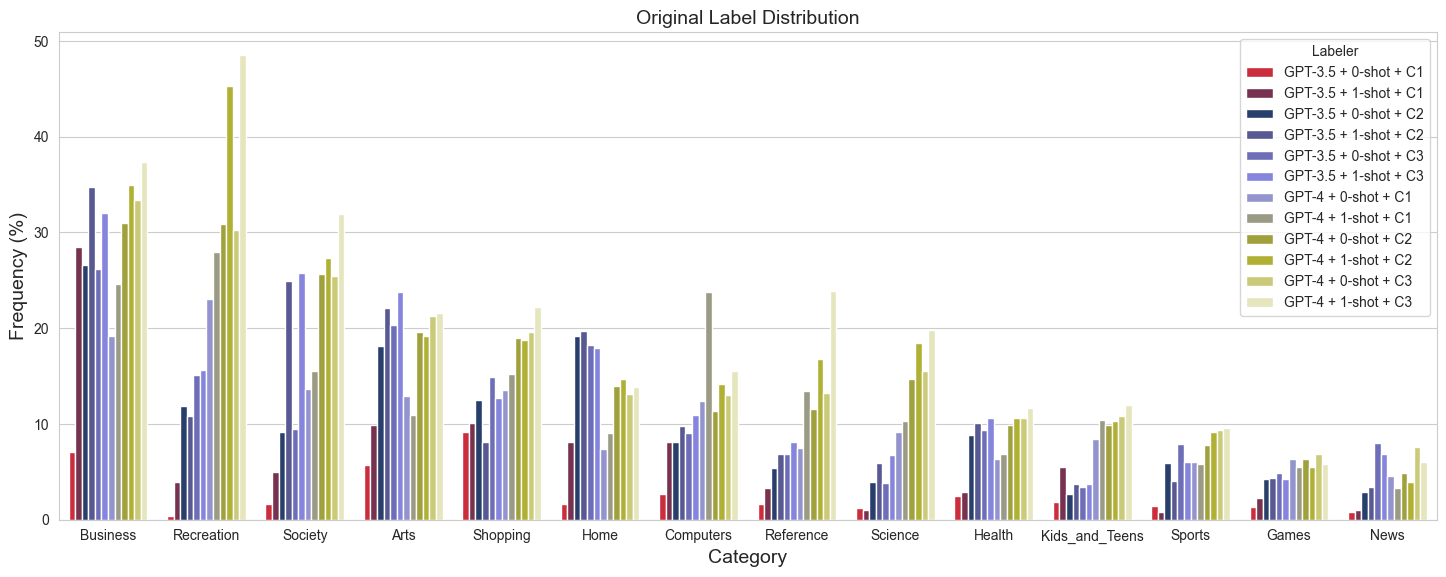

In [25]:
def get_label_dist(labelers):
    rows = []
    for name, class_dist in {name: labeler.get_class_dist(normalise=True) for name, labeler in labelers.items()}.items():
        for category, freq in class_dist.items():
            rows.append({"labeler": get_labeler_name(name), "category": category, "freq": 100 * freq})
    return pd.DataFrame(rows)

label_dist = get_label_dist(gpt_labelers)
fig, ax = plt.subplots(figsize=(15, 6))
fig.tight_layout(pad=3.0)
sns.barplot(
    label_dist,
    x="category",
    y="freq",
    hue="labeler",
    palette=palette,
    order=label_dist.groupby("category").sum().sort_values("freq", ascending=False).index,
    ax=ax
)
ax.get_legend().set_title("Labeler")
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Frequency (%)", fontsize=14)
ax.set_title("Original Label Distribution", fontsize=14)

print(f"✅ Plotted figure to {path}")

### Labeling Quality: Macro F1, Precision, Recall, etc.

The goal of all GPT labelers is to replicate the ground truth labels provide by the human annotators as closely as possible. As we only have human annotations for the crowdsourcede dataset, we can only evaluate the labelers on this dataset.

In [26]:
# Initialise crowdsourced config and labeler
crowdsourced_data_cfg = hydra.compose(config_name="eda", overrides=["data=crowdsourced"])
human_labeler_cfg = hydra.compose(config_name="eda", overrides=["labeler=human", "data=crowdsourced"])

# Instantitate
crowdsourced_data = hydra.utils.instantiate(crowdsourced_data_cfg.data)
human_labeler = hydra.utils.instantiate(human_labeler_cfg.labeler, data=crowdsourced_data)

In [27]:
def match_labels(labeler1, labeler2, subset = None):
    labels1 = labeler1.get_labels()
    labels2 = labeler2.get_labels()
    wid1 = set(labels1.keys())
    wid2 = set(labels2.keys())
    matched_wid = wid1 & wid2
    if subset:
        matched_wid = matched_wid & subset

    labels1 = np.array([labels1[wid]["labels"] for wid in matched_wid])
    labels2 = np.array([labels2[wid]["labels"] for wid in matched_wid])

    return labels1, labels2

In [28]:
def get_labeler_perf(labeler):
    labels1, labels2 = match_labels(human_labeler, labeler)

    acc = accuracy_score(labels1.flatten(), labels2.flatten())
    subset_acc = accuracy_score(labels1, labels2)
    macro_f1 = f1_score(labels1, labels2, average="macro")
    micro_f1 = f1_score(labels1, labels2, average="micro")
    weighted_f1 = f1_score(labels1, labels2, average="weighted")
    macro_precision = precision_score(labels1, labels2, average="macro", zero_division=0)
    micro_precision = precision_score(labels1, labels2, average="micro", zero_division=0)
    macro_recall = recall_score(labels1, labels2, average="macro", zero_division=0)
    micro_recall = recall_score(labels1, labels2, average="micro", zero_division=0)

    return {
        "acc": acc,
        "subset_acc": subset_acc,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "micro_precision": micro_precision,
        "macro_recall": macro_recall,
        "micro_recall": micro_recall,
    }

In [29]:
labeler_perf = pd.DataFrame([get_labeler_perf(labeler) for labeler in gpt_labelers.values()], 
                            index=[get_labeler_name(name) for name in gpt_labelers.keys()])
labeler_perf

,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
GPT-3.5 + 0-shot + C1,0.827013,0.085414,0.159570,0.162653,0.155489,0.635233,0.606780,0.097283,0.093914
GPT-3.5 + 1-shot + C1,0.826826,0.091984,0.232630,0.289017,0.277751,0.565566,0.544267,0.161507,0.196747
GPT-3.5 + 0-shot + C2,0.836306,0.139290,0.375855,0.412003,0.411554,0.562262,0.576415,0.297584,0.320567
GPT-3.5 + 1-shot + C2,0.832551,0.127464,0.386863,0.440402,0.440510,0.526652,0.547582,0.320552,0.368311
GPT-3.5 + 0-shot + C3,0.828046,0.128778,0.372394,0.409794,0.410367,0.499444,0.530885,0.314836,0.333683
GPT-3.5 + 1-shot + C3,0.821476,0.115637,0.377024,0.426071,0.428640,0.464730,0.501420,0.328673,0.370409
GPT-4 + 0-shot + C1,0.820537,0.095926,0.355475,0.373115,0.374361,0.474167,0.497378,0.295117,0.298531
GPT-4 + 1-shot + C1,0.808804,0.069645,0.361039,0.381791,0.385413,0.452552,0.452844,0.320988,0.330010
GPT-4 + 0-shot + C2,0.828515,0.115637,0.453939,0.485497,0.490625,0.499528,0.524012,0.429976,0.452256
GPT-4 + 1-shot + C2,0.820255,0.086728,0.459306,0.496450,0.505203,0.484074,0.497628,0.461682,0.495278


### Analysis

In [30]:
# Join with labeling statistics
labelers_df = pd.concat([labeler_info, labeler_statistics, labeler_perf], axis=1)

In [31]:
# Top-k performing labeler
top_k = 5
labelers_df.sort_values("macro_f1", ascending=False).head(top_k)

,model,context,shot,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost,cost_per_1k_page,acc,subset_acc,macro_f1,micro_f1,weighted_f1,macro_precision,micro_precision,macro_recall,micro_recall
GPT-4 + 1-shot + C3,gpt-4-1106-preview,context3,True,761,0,2.80 ± 1.30,7.93 ± 2.70,615.13 ± 124.30,94.68 ± 6.23,6.842570,8.991551,0.809461,0.077530,0.461246,0.496777,0.509009,0.457310,0.470865,0.492367,0.525708
GPT-4 + 1-shot + C2,gpt-4-1106-preview,context2,True,761,0,2.49 ± 1.28,5.16 ± 2.35,448.30 ± 60.33,92.29 ± 2.52,5.518490,7.251629,0.820255,0.086728,0.459306,0.496450,0.505203,0.484074,0.497628,0.461682,0.495278
GPT-4 + 0-shot + C2,gpt-4-1106-preview,context2,False,761,0,2.16 ± 1.03,5.73 ± 1.98,206.30 ± 60.33,106.61 ± 7.14,4.003900,5.261367,0.828515,0.115637,0.453939,0.485497,0.490625,0.499528,0.524012,0.429976,0.452256
GPT-4 + 0-shot + C3,gpt-4-1106-preview,context3,False,761,0,2.30 ± 1.11,9.44 ± 3.09,350.13 ± 124.30,105.80 ± 8.67,5.079990,6.675414,0.820631,0.099869,0.440991,0.477441,0.484140,0.461169,0.498572,0.433199,0.458027
GPT-3.5 + 1-shot + C2,gpt-3.5-turbo-1106,context2,True,761,0,1.68 ± 1.15,2.85 ± 0.42,448.30 ± 60.33,93.11 ± 4.06,0.482875,0.634527,0.832551,0.127464,0.386863,0.440402,0.440510,0.526652,0.547582,0.320552,0.368311


In [32]:
# Export table to latex
df = labelers_df.copy()

df["model"] = df["model"].apply(lambda x: rename_dict[x])
df["context"] = df["context"].apply(lambda x: rename_dict[x])
df["shot"] = df["shot"].apply(lambda x: rename_dict[x])
df["macro_f1"] = 100 * df["macro_f1"]

grouped = df.groupby(by=["model", "context", "shot"]).size()
df.index = pd.MultiIndex.from_tuples(grouped.index)

cols = {"lpp": "LPP", "cost_per_1k_page": "Cost ($)", "macro_f1": "M.-F1 (%)"}
df = df[cols.keys()].rename(columns=cols)

# Save the dataframe to a latex table
position = "!ht"
latex = df.to_latex(
    caption="\\textbf{Labeler Statistics.}", 
    label="tab:labeler-results",
    escape=True,
    float_format="%.2f",
    position=position,
    multirow=True,
    multicolumn=True,
    multicolumn_format="c",
)

# Add \centering right after \begin{table}
latex = latex.replace("\\begin{table}" + f"[{position}]", "\\begin{table}" + f"[{position}]" + "\n\\centering")
latex = latex.replace("[t]", "[c]")
print("❌ Saving disabled to prevent accidental overwrite - only turn on if numbers changed")
# save_path = os.path.join(TABLE_DIR, "labeler-results.tex")
# with open(save_path, "w") as f:
#     f.write(latex)
# print(f"✅ Saved table to {save_path}")

❌ Saving disabled to prevent accidental overwrite - only turn on if numbers changed


✅ Plotted figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/data/meta/categories.json


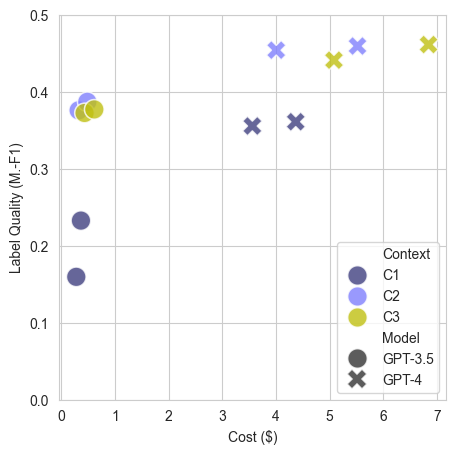

In [33]:
# Time-cost tradeoff
df = labelers_df.copy()
df["time"] = df["durations"].apply(lambda x: x.split(" ± ")[0]).astype(float)
df["cost"] = df["estimated_cost"].astype(float)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=df,
    x="cost",
    y="macro_f1",
    style="model",
    hue="context",
    palette=palette,
    s=200,
    alpha=0.8,
)
ax.set_ylim(0, 0.5)
ax.set_xlabel("Cost ($)")
ax.set_ylabel("Label Quality (M.-F1)")

# Rename legend labels
handles, labels = ax.get_legend_handles_labels()
labels = [f"{rename_dict.get(label, label)}" for label in labels]
ax.legend(handles=handles, labels=labels)

print(f"✅ Plotted figure to {path}")

✅ Plotted labeler quality as function of model, context and shot


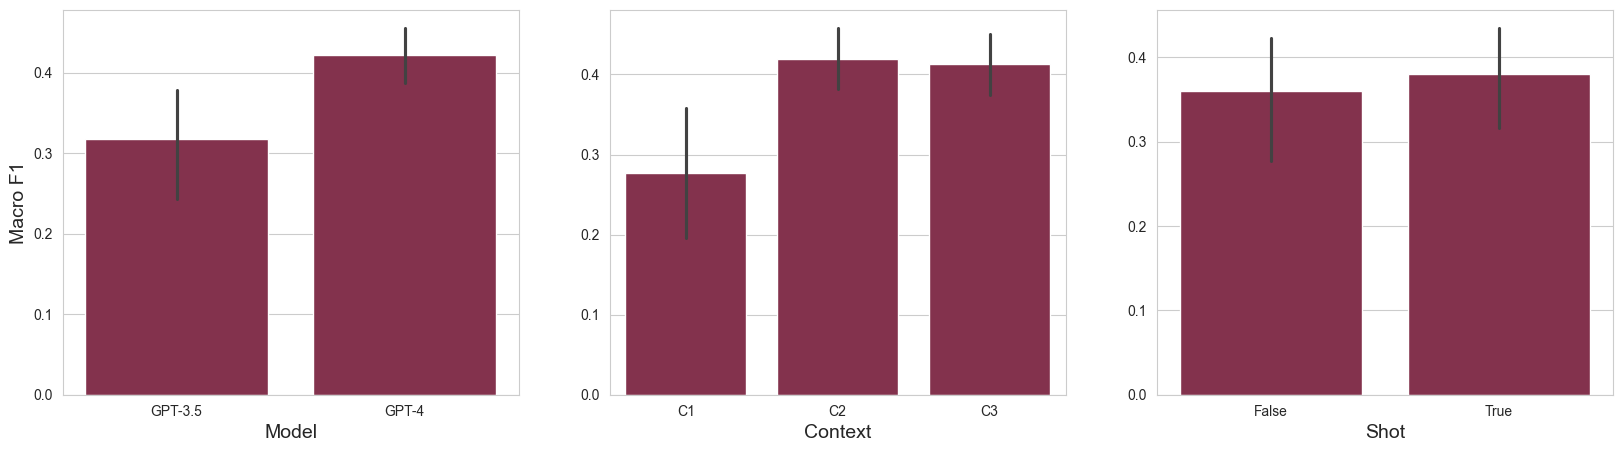

In [34]:
# Univariate performance
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
xs = ["model", "context", "shot"]

for ax, x in zip(axs, xs):
    sns.barplot(
        data=labelers_df,
        x=x,
        y="macro_f1",
        ax=ax
    )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([rename_dict.get(t.get_text(), t.get_text()) for t in ax.get_xticklabels()])
    ax.set_xlabel(x.capitalize(), fontsize=14)
    ax.set_ylabel("")

axs[0].set_ylabel("Macro F1", fontsize=14)

print(f"✅ Plotted labeler quality as function of model, context and shot")

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/labeler-grid.pdf


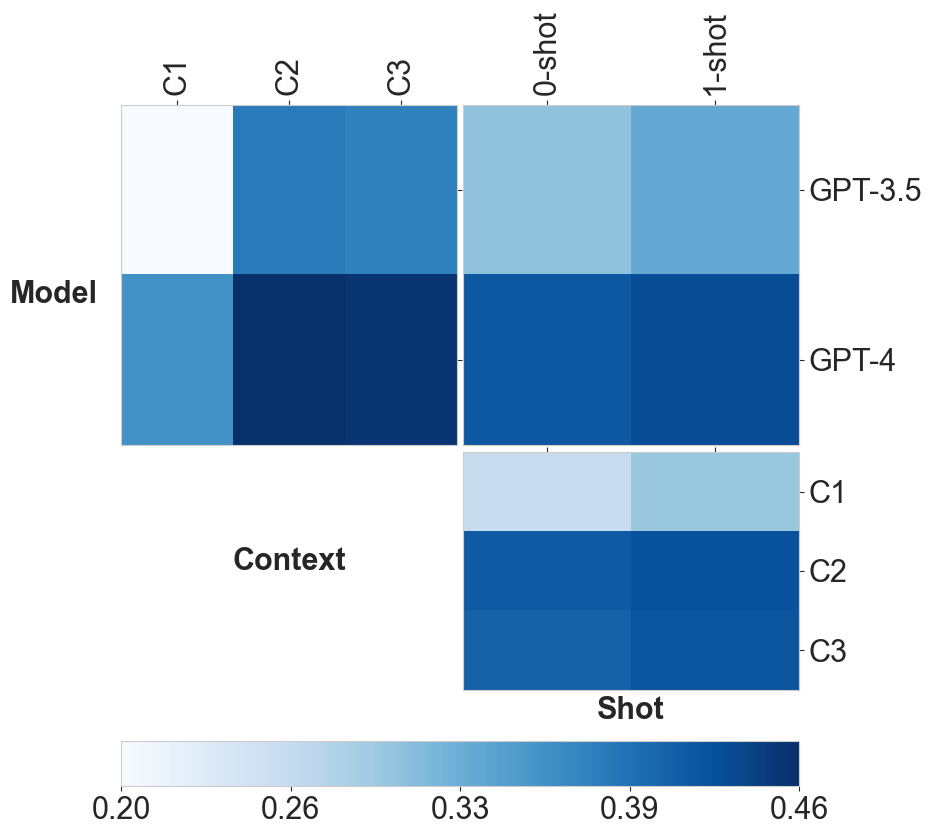

In [35]:
# Labeler parameters
params = ["model", "context", "shot"]
fig = utils.grid(labelers_df, params, metric="macro_f1", agg="mean", cmap="Blues", figsize=(8, 8), rename_dict=rename_dict) 

path = os.path.join(FIGURE_DIR, "labeler-grid.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")

### Labeling Quality: Annotator agreeement between GPT and Human

We have seen in the [preprocesssing notebook](preprocessing.ipynb) that the inter annotator agreement per website on average between humans measured via Cohen's Kappa was already relatively low ($0.2$). In this section, we therefore focus on measuring the agreement level between the GPT labelers and the human annotators.

In [36]:
gpt_human_agg = dict()
human_labels = np.array([v["labels"] for v in human_labeler.get_labels().values()])
for name, labeler in gpt_labelers.items():

    # Obtain 2d array with labels for each website (n_websites, n_categories)
    gpt_labels = np.array([v["labels"] for v in labeler.get_labels().values()])
    k = gpt_labels.shape[1]

    # Ensure matching between human and gpt labels
    human_labs_matched, gpt_labs_matched = match_labels(human_labeler, labeler)

    kappa_scores = []
    for j in range(k):

        # Obtain the labels for kth class by human and gpt
        human_kthcls_labels = human_labs_matched[:, j]
        gpt_kthcls_labels = gpt_labs_matched[:, j]

        # Compute the cohens kappa score
        kappa = cohen_kappa_score(human_kthcls_labels, gpt_kthcls_labels)

        # Append to list
        kappa_scores.append(kappa)


    # Save the results
    gpt_human_agg[name] = kappa_scores

Let's now evalute the results, first we look at the overall picture using dataframe:

In [37]:
aggreement_df = pd.DataFrame(gpt_human_agg, index=categories).round(2)
aggreement_df

,gpt3.5-zeroshot-context1,gpt3.5-oneshot-context1,gpt3.5-zeroshot-context2,gpt3.5-oneshot-context2,gpt3.5-zeroshot-context3,gpt3.5-oneshot-context3,gpt4-zeroshot-context1,gpt4-oneshot-context1,gpt4-zeroshot-context2,gpt4-oneshot-context2,gpt4-zeroshot-context3,gpt4-oneshot-context3
Arts,0.16,0.29,0.47,0.47,0.46,0.42,0.33,0.30,0.48,0.49,0.47,0.51
Business,0.03,0.14,0.23,0.28,0.22,0.27,0.16,0.15,0.26,0.34,0.26,0.34
Computers,0.15,0.21,0.35,0.36,0.35,0.34,0.23,0.16,0.40,0.38,0.35,0.35
Games,0.21,0.30,0.38,0.40,0.42,0.40,0.25,0.28,0.38,0.39,0.34,0.36
Health,0.22,0.18,0.42,0.40,0.39,0.38,0.36,0.34,0.45,0.43,0.46,0.43
Home,0.03,0.01,0.11,0.09,0.06,0.08,0.13,0.16,0.15,0.16,0.13,0.21
Kids_and_Teens,0.10,0.18,0.15,0.17,0.08,0.15,0.27,0.21,0.25,0.34,0.23,0.31
News,0.14,0.13,0.29,0.27,0.24,0.21,0.25,0.23,0.29,0.30,0.25,0.32
Recreation,0.01,0.12,0.29,0.25,0.27,0.18,0.24,0.21,0.32,0.25,0.31,0.21
Reference,0.04,0.06,0.18,0.19,0.12,0.04,0.20,0.29,0.29,0.27,0.25,0.24


Let's now get some insights about the statistics of the agreement level between the GPT labelers and the human annotators:

In [38]:
agreement_stats = aggreement_df.describe().round(2)
agreement_stats

,gpt3.5-zeroshot-context1,gpt3.5-oneshot-context1,gpt3.5-zeroshot-context2,gpt3.5-oneshot-context2,gpt3.5-zeroshot-context3,gpt3.5-oneshot-context3,gpt4-zeroshot-context1,gpt4-oneshot-context1,gpt4-zeroshot-context2,gpt4-oneshot-context2,gpt4-zeroshot-context3,gpt4-oneshot-context3
count,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00,14.00
mean,0.12,0.16,0.29,0.29,0.28,0.27,0.26,0.25,0.35,0.35,0.33,0.34
std,0.08,0.09,0.11,0.10,0.13,0.12,0.07,0.07,0.09,0.08,0.10,0.08
min,0.01,0.01,0.11,0.09,0.06,0.04,0.13,0.15,0.15,0.16,0.13,0.21
25%,0.04,0.10,0.20,0.26,0.21,0.19,0.23,0.21,0.29,0.31,0.25,0.31
50%,0.13,0.14,0.29,0.29,0.26,0.30,0.25,0.26,0.36,0.36,0.34,0.35
75%,0.16,0.20,0.38,0.35,0.39,0.36,0.30,0.31,0.42,0.40,0.38,0.36
max,0.25,0.30,0.47,0.47,0.46,0.42,0.36,0.34,0.48,0.49,0.47,0.51


We can see that as the complexity of the labeler increases, the more average agreement we obtain with the human annotators with plus or minus same standard deviation. Interestingly, we can see that for some categories  and gpt4 based labelers we obtain almost $0.5$ agreement. 

### Curlie

In this section we explore the labels of the `curlie-1000` that we relabel with the most promising GPT labelers given the label quality and cost of labeling as shown in the section above.

In [39]:
# Initialise data and labeler config
curlie_cfg = hydra.compose(config_name="eda", overrides=["data=curlie"])
curlie_labeler_names = ["gpt3.5-oneshot-context2", "gpt4-zeroshot-context2"]
curlie_labeler_cfg = {name: hydra.compose(config_name="eda", overrides=[f"labeler={name}"]) for name in curlie_labeler_names}

In [40]:
# Instantiate data
curlie_data = hydra.utils.instantiate(curlie_cfg.data)
curlie_labeler = {name: hydra.utils.instantiate(curlie_labeler.labeler, data=curlie_data) for name, curlie_labeler in curlie_labeler_cfg.items()}
print(f"✅ Initialised {len(curlie_labeler)} labeler(s).")

✅ Initialised 2 labeler(s).


We expect that the LPP will be higher as the labelers have learned to replicate the human labels.

In [41]:
values = [get_statistics(labeler) for labeler in curlie_labeler.values()]
index = [get_labeler_name(name) for name in curlie_labeler.keys()]
labeler_statistics = pd.DataFrame(values, index=index)
labeler_statistics

,valid,invalid,lpp,durations,prompt_tokens,completion_tokens,estimated_cost,cost_per_1k_page
GPT-3.5 + 1-shot + C2,9190,0,1.60 ± 1.08,2.09 ± 1.04,470.16 ± 87.36,92.99 ± 3.85,6.029949,0.656142
GPT-4 + 0-shot + C2,9190,0,2.03 ± 0.97,7.80 ± 3.32,228.16 ± 87.36,106.16 ± 8.10,50.235890,5.466365


Let's first look at the distribution of labels for each category.

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures/curlie-10k-dist.pdf


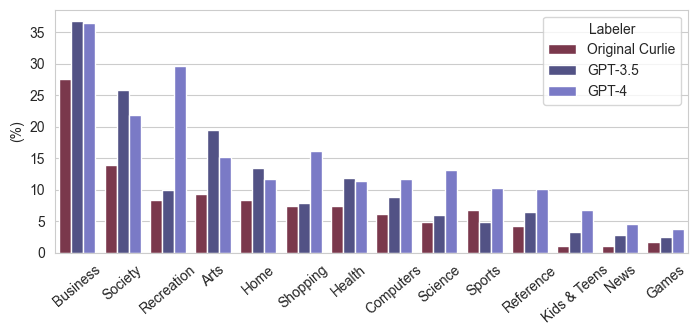

In [42]:
# Plot label distribution
label_dist = get_label_dist(curlie_labeler)
original_curlie_dist = {
 'Business': 27.6,
 'Society': 13.9,
 'Arts': 9.3,
 'Home': 8.4,
 'Health': 7.4,
 'Recreation': 8.4,
 'Computers': 6.2,
 'Shopping': 7.4,
 'Reference': 4.3,
 'Science': 4.8,
 'Sports': 6.8,
 'Kids_and_Teens': 1.1,
 'News': 1.1,
 'Games': 1.7
}
for category, freq in original_curlie_dist.items():
    label_dist.loc[len(label_dist)] = ["Original Curlie", category, freq]

renamer2 = {"Original Curlie": "Original Curlie", "GPT-3.5 + 1-shot + C2": "GPT-3.5", "GPT-4 + 0-shot + C2": "GPT-4"}
label_dist["labeler"] = label_dist["labeler"].apply(lambda x: renamer2[x])

label_dist["labeler"] = pd.Categorical(label_dist['labeler'], ["Original Curlie", "GPT-3.5", "GPT-4"], ordered=True)
labeler_dist = label_dist.sort_values("labeler")

fig, ax = plt.subplots(figsize=(7, 3))
fig.tight_layout(pad=1.0)
sns.barplot(
    label_dist,
    y="freq",
    x="category",
    hue="labeler",
    order=label_dist.groupby("category").sum({"freq": "sum"}).sort_values("freq", ascending=False).index,
    palette={"Original Curlie": "#852D48", "GPT-3.5": "#49498D", "GPT-4": "#6D6DD3"},
    ax=ax
)
ax.get_legend().set_title("Labeler")
ax.set_xlabel("")
ax.set_ylabel("(%)")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([rename_dict.get(x.get_text(), x.get_text()) for x  in ax.get_xticklabels()], rotation=40)

path = os.path.join(FIGURE_DIR, "curlie-10k-dist.pdf")
fig.savefig(path, bbox_inches="tight")
print(f"✅ Saved figure to {path}")